In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
import pandas as pd
import numpy as np
import re
import string

from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS, CountVectorizer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

In [2]:
df = pd.read_csv('ggr_text_data_v2.csv', index_col=0)

In [3]:
df.head()

,url,text,title
0,https://www.garagegymreviews.com/nike-metcon-5...,"By Coopupdated November 9, 2021We review free ...",Nike Metcon 5 Shoes Leaked (PLUS Mat Fraser's ...
1,https://www.garagegymreviews.com/nike-metcon-7...,"By Coopupdated November 9, 2021We review free ...",Nike Metcon 7 Shoes Review (2021)
2,https://www.garagegymreviews.com/nike-metcon-1...,"By Coopupdated November 9, 2021We review free ...",Nike Metcon 1 vs. Nike Metcon 2
3,https://www.garagegymreviews.com/kabuki-streng...,"By Coopupdated November 9, 2021We review free ...",Kabuki Strength Kadillac Bar Review
4,https://www.garagegymreviews.com/garmin-foreru...,"By Coopupdated November 9, 2021We review free ...",Garmin Forerunner 245 Review (2021)


In [4]:
def preprocessing(df):
    whitespace_token = RegexpTokenizer("\s+|[\.?!-]|[\u2026]", gaps=True) #split on white space, (.?!), and (...)
    df['token_doc'] = df['text'].apply(whitespace_token.tokenize)
    stop_words = set(ENGLISH_STOP_WORDS)
    new_stop_words= ['lb','up','pound','color','black','on','kg','able','pull','lat']
    df['clean_doc'] = df['token_doc'].apply(lambda x: [word for word in x if word.lower() not in stop_words])
    
    def clean_data(data):
        lst = []
        for word in data:

            word = word.lower()
            word = re.sub(r'''[!()[\]{};?@#$%:\'\"\,.^&*_`]''','',word) #remove all punctuation 
            word = re.sub(r'\w*\d\w*','',word) #remove all number and words containing numbers
            word = re.sub(u'[\u201C]|[\u201D]','',word) #remove special "" with unicode
            word = re.sub(r'(^| ).( |$)','',word) #remove any character that is one unit in length
            #word = re.sub(r'(^| )\d{2,}( |$)','',word) #remove any number that is two or more units in length alone on a line

            lst.append(word)
        return lst

    def remove_white_space(data):
        while '' in data:
            data.remove('')
        return data

    df['clean_doc'] = df['clean_doc'].apply(clean_data)
    
    df['clean_doc'] = df['clean_doc'].apply(remove_white_space)
    
    wordnet_lemmatizer = WordNetLemmatizer()
    df['clean_doc'] = df['clean_doc'].apply(lambda x: [wordnet_lemmatizer.lemmatize(word) for word in x])
    
    df_clean = df['clean_doc']
    
    df_clean = df_clean.apply(lambda x: ' '.join(map(str,x)))
    
    return df_clean

In [5]:
df_clean = preprocessing(df)

## NMF

In [6]:
tfidf = TfidfVectorizer(min_df=0.01, max_df=0.6)

doc_word_matrix_tf = tfidf.fit_transform(df_clean)
tf_df = pd.DataFrame(doc_word_matrix_tf.toarray(), columns=tfidf.get_feature_names())
vocab = tfidf.get_feature_names()

In [7]:
tf_df.shape #Document-Term Matrix

(432, 5781)

In [8]:
nmf = NMF(n_components=10, init=None,alpha=0)

doc_topic_mx = nmf.fit_transform(doc_word_matrix_tf)

In [9]:
nmf.n_iter_

55

In [10]:
doc_topic_mx.shape #Document-Topic Matrix

(432, 10)

In [45]:
ex_labels = df['title']
doc_topic_df = pd.DataFrame(doc_topic_mx, index = ex_labels).add_prefix('Topic_')
doc_topic_df.head()

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
title,,,,,,,,,,
Nike Metcon 5 Shoes Leaked (PLUS Mat Fraser's Edition),0.000000,0.310123,0.006786,0.01099,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Nike Metcon 7 Shoes Review (2021),0.000093,0.344294,0.000000,0.00216,0.000000,0.000179,0.00000,0.000323,0.026383,0.000000
Nike Metcon 1 vs. Nike Metcon 2,0.000000,0.252215,0.023800,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
Kabuki Strength Kadillac Bar Review,0.097418,0.000000,0.069066,0.00000,0.011955,0.000000,0.00000,0.028060,0.000000,0.000000
Garmin Forerunner 245 Review (2021),0.009811,0.004056,0.000000,0.00000,0.000685,0.002815,0.00154,0.000000,0.178257,0.001304


In [14]:
nmf.components_.shape #Topic-Term Matrix

(10, 5781)

In [15]:
n_terms = 10     # Select the top 10 words in vocab for each topic.
for idx, topic in enumerate(nmf.components_):
    top_words = [vocab[i].upper() for i in topic.argsort()[:-n_terms-1:-1]]
    print(f"Topic {idx}:\n", ", ".join(top_words), "\n")

Topic 0:
 HOLE, UPRIGHT, PULL, ATTACHMENT, SORINEX, MONSTER, BAND, TITAN, LAT, HANDLE 

Topic 1:
 SHOE, NIKE, METCON, HEEL, NANO, REEBOK, ROMALEOS, WEIGHTLIFTING, FOOT, TOE 

Topic 2:
 OHIO, KNURL, SHAFT, SLEEVE, KNURLING, BUSHING, TENSILE, STAINLESS, PSI, CERAKOTE 

Topic 3:
 BIKE, AIR, ECHO, ASSAULT, SCHWINN, MONITOR, SEAT, PEDAL, AIRDYNE, FAN 

Topic 4:
 DUMBBELL, ADJUSTABLE, HANDLE, POWERBLOCK, POWERBLOCKS, BOWFLEX, LB, POUND, IRONMASTER, KETTLEBELL 

Topic 5:
 BELT, PIONEER, LEATHER, DOMINION, BUCKLE, SBD, PRONG, LEVER, RHINO, WEIGHTLIFTING 

Topic 6:
 BUMPER, FRINGESPORT, RUBBER, BOUNCE, URETHANE, POUND, COMPETITION, ALPHA, VIRGIN, COLOR 

Topic 7:
 BENCH, PAD, FLAT, ADJUSTABLE, FAT, UTILITY, REP, FB, FOOT, THOMPSON 

Topic 8:
 TREADMILL, MACHINE, IFIT, ELLIPTICAL, RUNNING, TRUEFORM, NORDICTRACK, APP, RUNNER, TRAINER 

Topic 9:
 VEST, CARRIER, WEIGHTED, HYPER, VELCRO, HYPERWEAR, EZ, SLED, POCKET, BOX 



In [28]:
# This finds the documents that are most heavily correlated with each topic.
doc_topic_df.idxmax()

Topic_0         The Best Squat Racks for 2021 [Buying Guide]
Topic_1                        7 Best CrossFit Shoes of 2021
Topic_2                   The Best Olympic Barbells for 2021
Topic_3                           The Best Air Bike for 2021
Topic_4    The Best Adjustable Dumbbells for Home Gyms (2...
Topic_5                The Best Weightlifting Belts for 2021
Topic_6                      The Best Bumper Plates for 2021
Topic_7                    The 8 Best Weight Benches of 2021
Topic_8                    The 11 Best Treadmills for (2021)
Topic_9    The Best Weighted Vest for 2021: Plate Carrier...
dtype: object

In [29]:
# This finds highest frequency in each topic.
doc_topic_df.max()

Topic_0    0.266219
Topic_1    0.471710
Topic_2    0.470036
Topic_3    0.536134
Topic_4    0.565428
Topic_5    0.494336
Topic_6    0.510987
Topic_7    0.416549
Topic_8    0.455212
Topic_9    0.689472
dtype: float64

## Recommendation System

In [16]:
doc_array = pairwise_distances(doc_topic_mx[3].reshape(1,-1),doc_topic_mx,metric='cosine').argsort()[0][1:3+1]
df_out = df[['title', 'url']].iloc[doc_array,:]
df_out

,title,url
33,Kabuki Strength Transformer Bar V4 Review,https://www.garagegymreviews.com/kabuki-streng...
218,The Best Safety Squat Bar for 2021,https://www.garagegymreviews.com/the-best-safe...
425,Rogue SB-1 Safety Squat Bar Review,https://www.garagegymreviews.com/rogue-safety-...


In [17]:
from tabulate import tabulate

def get_recommendations(blog_num, num_match=3):
    doc_array = pairwise_distances(doc_topic_mx[blog_num].reshape(1,-1),doc_topic_mx,metric='cosine').argsort()[0][1:num_match+1]
    df_out = df[['title', 'url']].iloc[doc_array,:]
    print('You read: {} \n\nYou might like:\n\n {}'.format(df['title'][blog_num],tabulate(df_out, headers=['Idx:','Title:', 'URL:'],tablefmt="plain") ))
        


In [18]:
get_recommendations(6)

You read: Rogue US MIL Spec Bumper Plates Review (2021) 

You might like:

   Idx:  Title:                                             URL:
    30  FringeSport Bumper Plates Review                   https://www.garagegymreviews.com/fringesport-bumper-plates-in-depth-review
   289  Vulcan Strength Alpha Bumper Plates Review (2021)  https://www.garagegymreviews.com/vulcan-strength-alpha-bumper-plates-review
   209  The Best Bumper Plates for 2021                    https://www.garagegymreviews.com/best-bumper-plates-guide


## Topic Pipeline

In [19]:
def make_topics(corpus, vectorizer, topic_modeler, print_n_words=15):
    """A very simple pipeline."""
    
#     # Apply preprocessor, vectorizer, and topic modeler.
#     if preprocessor is not None:
#         docs = docs.apply(preprocessor)
    
    # Vectorize documents into a document-word matrix.
    doc_word_vectors = vectorizer.fit_transform(corpus)
    
    # Fit the topic model.
    doc_topic_vectors = topic_modeler.fit_transform(doc_word_vectors)
    
    # Print the topics.
    vocab = vectorizer.get_feature_names()
    for idx, topic in enumerate(topic_modeler.components_):
        # Select the top 15 words in vocab for this topic.
        top_words = [vocab[i].upper() for i in topic.argsort()[:-print_n_words-1:-1]]
        print(f"Topic {idx}:\n", ", ".join(top_words), "\n")
    
    return doc_topic_vectors

In [20]:
corpus = df_clean
vectorizer = TfidfVectorizer(min_df=0.01, max_df=0.6)
topic_modeler = NMF(n_components=10, init=None,alpha=0)

In [21]:
make_topics(corpus,vectorizer,topic_modeler)

Topic 0:
 HOLE, UPRIGHT, PULL, ATTACHMENT, SORINEX, MONSTER, BAND, TITAN, LAT, HANDLE, PR, REP, MACHINE, SLED, GAUGE 

Topic 1:
 SHOE, NIKE, METCON, HEEL, NANO, REEBOK, ROMALEOS, WEIGHTLIFTING, FOOT, TOE, OUTSOLE, UPPER, MIDSOLE, ADIDAS, STABILITY 

Topic 2:
 OHIO, KNURL, SHAFT, SLEEVE, KNURLING, BUSHING, TENSILE, STAINLESS, PSI, CERAKOTE, ZINC, POWERLIFTING, OLYMPIC, FINISH, SPIN 

Topic 3:
 BIKE, AIR, ECHO, ASSAULT, SCHWINN, MONITOR, SEAT, PEDAL, AIRDYNE, FAN, XEBEX, CALORIE, RESISTANCE, CONSOLE, RIDE 

Topic 4:
 DUMBBELL, ADJUSTABLE, HANDLE, POWERBLOCK, POWERBLOCKS, BOWFLEX, LB, POUND, IRONMASTER, KETTLEBELL, IRONMASTERS, HEX, SELECTTECH, DB, MUSCLE 

Topic 5:
 BELT, PIONEER, LEATHER, DOMINION, BUCKLE, SBD, PRONG, LEVER, RHINO, WEIGHTLIFTING, BRUTE, PLY, TROLLEY, PLATFORM, CUT 

Topic 6:
 BUMPER, FRINGESPORT, RUBBER, BOUNCE, URETHANE, POUND, COMPETITION, ALPHA, VIRGIN, COLOR, REP, IRON, DUROMETER, CRUMB, INSERT 

Topic 7:
 BENCH, PAD, FLAT, ADJUSTABLE, FAT, UTILITY, REP, FB, FOOT, T

array([[0.00000000e+00, 3.10140809e-01, 6.78662811e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.30731393e-05, 3.44313725e-01, 0.00000000e+00, ...,
        3.23668896e-04, 2.64088607e-02, 0.00000000e+00],
       [0.00000000e+00, 2.52228946e-01, 2.38010673e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 3.19508997e-01, ...,
        1.99332636e-03, 1.56199981e-03, 0.00000000e+00],
       [6.08842194e-02, 2.49798582e-03, 1.57802080e-02, ...,
        2.19651636e-02, 1.59415392e-02, 1.83344129e-02],
       [1.10603203e-02, 1.09430872e-02, 3.18229512e-03, ...,
        3.75758837e-01, 0.00000000e+00, 0.00000000e+00]])

## Multi Dimensional Scaling

In [22]:
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
mds = MDS()
array_mds_tf = mds.fit_transform(tf_df)
df_mds_tf = pd.DataFrame(array_mds_tf, columns = ['x','y'])

<AxesSubplot:xlabel='x', ylabel='y'>

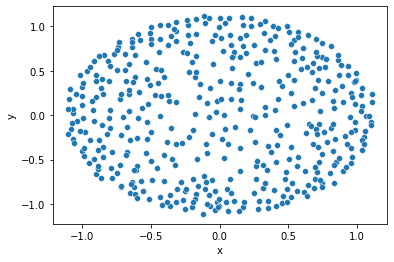

In [24]:
sns.scatterplot(x=df_mds_tf.x, y=df_mds_tf.y, data=df_mds_tf)

**Clustering with Topic Modeling**

Assign each document to the topic it is most heavily correlated with in the document-topic matrix.

In [25]:
top_lst = []
for i in range(0, 432):
    str1 = doc_topic_df.iloc[i,:].idxmax()
    top_lst.append(int(re.sub(r'[a-zA-Z_]','',str1)))

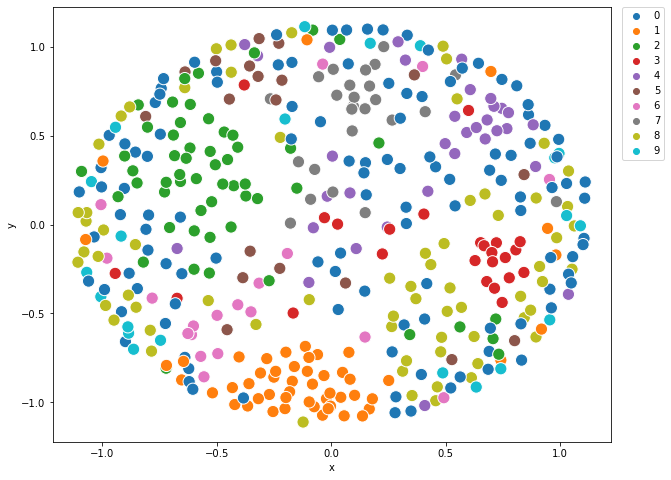

In [26]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=df_mds_tf.x, y=df_mds_tf.y, hue=top_lst, palette="tab10", data=df_mds_tf,s=150)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.savefig('Topic_Vis.png')

**Clustering with K-means**

In [31]:
from sklearn.cluster import KMeans

In [32]:
num_clusters = 13

km_doc_top = KMeans(n_clusters=num_clusters,random_state=20,n_init=10)
km_doc_top.fit(tf_df)

KMeans(n_clusters=13, random_state=20)

Creation of the cluster-topic matrix

In [36]:
cluster_labels_dt = km_doc_top.labels_
cluster_series = pd.Series(cluster_labels_dt, name='cluster')
df_cluster = doc_topic_df.copy(deep=True)
df_cluster = df_cluster.reset_index()
df_cluster = pd.concat([df_cluster,cluster_series], axis=1)

clust_topic_df=df_cluster.groupby('cluster').mean()#Cluster Topic Matrix
clust_topic_df

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
cluster,,,,,,,,,,
0,0.003213,0.004803,0.002757,0.026274,0.010235,0.012756,0.001029,0.002342,0.277340,0.001083
1,0.052727,0.013375,0.020322,0.016173,0.021657,0.007603,0.037131,0.010192,0.038980,0.011333
2,0.007224,0.291276,0.005295,0.006279,0.002602,0.006278,0.004273,0.003687,0.011876,0.009401
3,0.020358,0.010461,0.002431,0.005388,0.005925,0.005541,0.005513,0.010098,0.002095,0.397801
4,0.010738,0.003591,0.016073,0.000467,0.402295,0.002114,0.020658,0.006674,0.008132,0.003564
5,0.005955,0.300399,0.006359,0.009663,0.000196,0.004508,0.006411,0.001751,0.003269,0.004609
6,0.006892,0.007614,0.292056,0.008963,0.004947,0.007741,0.009193,0.004592,0.008615,0.006245
7,0.031760,0.004188,0.003004,0.000550,0.007049,0.322750,0.004656,0.001705,0.011946,0.002272
8,0.058208,0.020438,0.009612,0.014208,0.025773,0.012576,0.008918,0.001329,0.051447,0.005814


In [37]:
#This defines which topic each cluster is most heavily correlated with.
clust_topic_df.idxmax(axis=1)

cluster
0     Topic_8
1     Topic_0
2     Topic_1
3     Topic_9
4     Topic_4
5     Topic_1
6     Topic_2
7     Topic_5
8     Topic_0
9     Topic_0
10    Topic_7
11    Topic_0
12    Topic_3
dtype: object

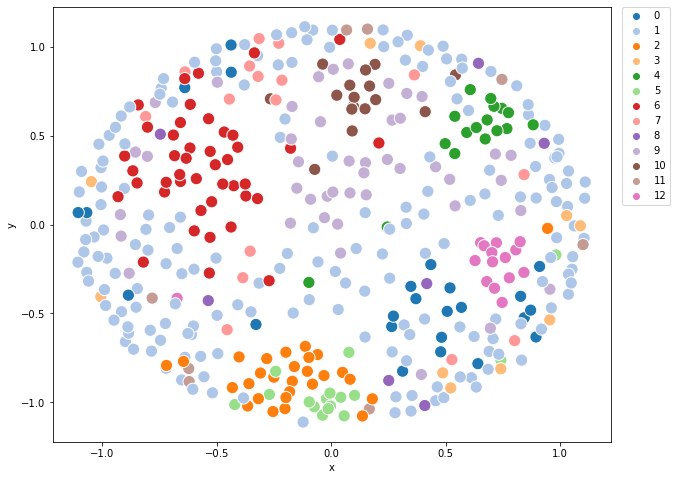

In [38]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=df_mds_tf.x, y=df_mds_tf.y, hue=cluster_labels_dt, palette="tab20", data=df_mds_tf, s=150)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

## Term Frequency Chart

In [43]:
term_weights = nmf.components_[3,:]
term_index = term_weights.argsort()[:-15:-1]

s1_lst = [x.upper() for x in list(tf_df.columns[term_index])]
s1 = pd.Series(s1_lst, name="Term")
s2 = pd.Series(np.sort(term_weights)[:-15:-1], name='Frequency')
df_t = pd.concat([s1,s2], axis=1)
df_t

,Term,Frequency
0,BIKE,1.357513
1,AIR,0.400444
2,ECHO,0.342169
3,ASSAULT,0.269305
4,SCHWINN,0.248131
5,MONITOR,0.188191
6,SEAT,0.187738
7,PEDAL,0.184313
8,AIRDYNE,0.182818
9,FAN,0.179257


<AxesSubplot:xlabel='Term', ylabel='Frequency'>

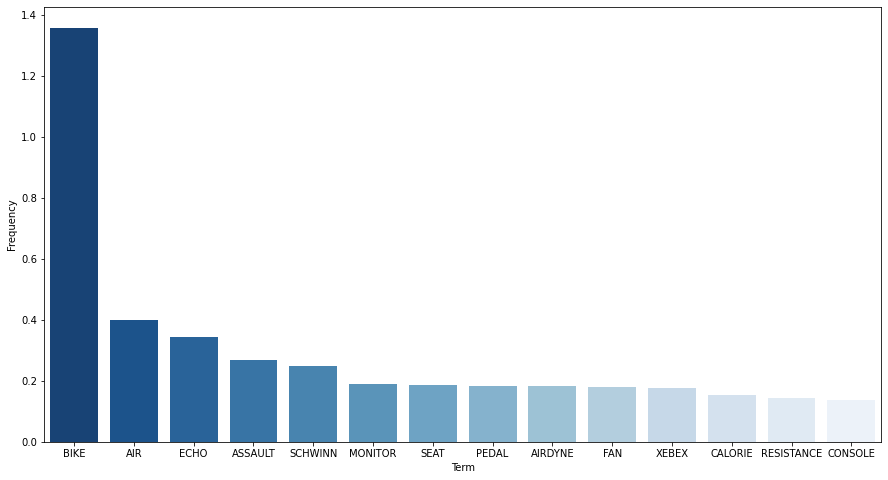

In [44]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_t['Term'], y=df_t['Frequency'],palette="Blues_r")